In [19]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from hd_extension import *

In [20]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Hab Dishab/all/nac"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Hab Dishab/all_csvs/nac_csvs"
brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

In [21]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Hab Dishab/all/nac/n7-240821-114717/Notes.txt
read from t=0s to t=1309.86s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Hab Dishab/all/nac/n2-240507-093913/Notes.txt
read from t=0s to t=1511.09s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Hab Dishab/all/nac/nn7-250114-100133/Notes.txt
read from t=0s to t=1376.66s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Hab Dishab/all/nac/nn3-250115-064154/Notes.txt
read from t=0s to t=1377.67s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Hab Dishab/all/nac/n6-240821-100116/Notes.txt
read from t=0s to t=1335.06s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Hab D

In [22]:
bout_definitions = [
    {'prefix': 's1', 'introduced': 's1_Introduced', 'removed': 's1_Removed'},
    {'prefix': 's2', 'introduced': 's2_Introduced', 'removed': 's2_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for n7-240821-114717...
Processing behaviors for n2-240507-093913...
Processing behaviors for nn7-250114-100133...
Processing behaviors for nn3-250115-064154...
Processing behaviors for n6-240821-100116...
Processing behaviors for nn1-250115-052028...
Processing behaviors for n1-240507-080133...
Processing behaviors for nn4-250115-072812...
Processing behaviors for n3-240507-115440...
Processing behaviors for nn2-250115-054951...
Processing behaviors for nn5-250114-083827...
Processing behaviors for n5-240821-085040...
Processing behaviors for nn6-250114-093117...
Processing behaviors for n4-240507-140651...
Processing behaviors for nn8-250114-103839...


# Total Investigation Time & Average Bout Duration

In [23]:
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    behavior_name="Investigation",   # or "Approach" if you prefer
    gap_threshold=0.3,
    min_duration=.00000000000000001,
    desired_bouts=desired_bouts,
    agg_func='sum'
)

In [24]:
def plot_y_across_bouts_gray(df,  
                             title='Mean Across Bouts', 
                             ylabel='Mean Value', 
                             custom_xtick_labels=None, 
                             custom_xtick_colors=None, 
                             ylim=None, 
                             bar_color='#00B7D7',
                             yticks_increment=None, 
                             xlabel='Agent',
                             figsize=(12,7), 
                             pad_inches=0.1):
    """
    Plots the mean values (with SEM) across bouts with individual-subject lines.
    Also performs a paired t-test comparing the average of s1-1 & s1-2 vs. the
    average of s1-5 & s2-2, drawing a significance line if p < 0.05.

    Parameters:
        - df (DataFrame): A DataFrame where rows are subjects, and bouts are columns.
                          Values are the mean values (e.g., mean DA, investigation times)
                          for each subject and bout.
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - custom_xtick_labels (list): Custom x-tick labels. If not provided,
                                      defaults to df column names.
        - custom_xtick_colors (list): A list of colors for the x-tick labels.
        - ylim (tuple): (min, max) for y-axis. If None, automatically set.
        - bar_color (str): The color for the bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - xlabel (str): The label for the x-axis.
        - figsize (tuple): The figure size.
        - pad_inches (float): Figure padding when saving.
    """
    # Calculate mean and SEM
    mean_values = df.mean()
    sem_values = df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Bar plot with error bars
    bars = ax.bar(
        df.columns, 
        mean_values, 
        yerr=sem_values, 
        capsize=6,
        color=bar_color,
        edgecolor='black', 
        linewidth=5,
        width=0.6,
        error_kw=dict(elinewidth=3, capthick=3, zorder=5)
    )

    # Plot all subject lines in gray
    for subject in df.index:
        ax.plot(df.columns, df.loc[subject],
                linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

    # Plot unfilled circle markers (larger size) in gray
    for subject in df.index:
        ax.scatter(df.columns, df.loc[subject], 
                   facecolors='none', edgecolors='gray',
                   s=120, alpha=0.6, linewidth=4, zorder=2)

    # Labels & Title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # Set x-ticks
    ax.set_xticks(np.arange(len(df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df.columns, fontsize=26)

    # Increase tick label size
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # Handle y-limits
    if ylim is None:
        # Automatically set based on data range
        all_values = np.concatenate([df.values.flatten(), mean_values.values.flatten()])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # Set y-ticks if increment is provided
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min),
                            np.ceil(y_max) + yticks_increment,
                            yticks_increment)
        ax.set_yticks(y_ticks)

    # Remove right & top spines, thicken left & bottom
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # -----------------------------------------------------
    #  Perform paired t-test: (s1-1 + s1-2) vs. (s1-5 + s2-2)
    # -----------------------------------------------------
    required_cols = {'s1-1', 's1-2', 's1-5', 's2-2'}
    if required_cols.issubset(set(df.columns)):
        from scipy.stats import ttest_rel
        group1 = df[['s1-1', 's1-2']].mean(axis=1)
        group2 = df[['s1-5', 's2-2']].mean(axis=1)
        t_stat, p_val = ttest_rel(group1, group2)

        # Determine significance symbol
        if p_val < 0.001:
            sig_symbol = '***'
        elif p_val < 0.01:
            sig_symbol = '**'
        elif p_val < 0.05:
            sig_symbol = '*'
        else:
            sig_symbol = None

        if sig_symbol is not None:
            # Find the x-indices for these columns
            x_s11 = df.columns.get_loc('s1-1')
            x_s12 = df.columns.get_loc('s1-2')
            x_s15 = df.columns.get_loc('s1-5')
            x_s22 = df.columns.get_loc('s2-2')

            # We'll place a line spanning the “mean of s1-1 & s1-2” group
            # to the “mean of s1-5 & s2-2” group.
            x1 = (x_s11 + x_s12) / 2
            x2 = (x_s15 + x_s22) / 2

            # Determine a suitable y-position: 
            # take the highest bar+SEM among the four columns
            bars_of_interest = ['s1-1', 's1-2', 's1-5', 's2-2']
            max_height = 0
            for c in bars_of_interest:
                bar_top = mean_values[c] + sem_values[c]
                if bar_top > max_height:
                    max_height = bar_top

            # We'll add 3% on top of that highest bar
            line_y = max_height * 1.03
            # A small offset to place the text above the line
            text_offset = 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])  

            # Draw a simple horizontal line
            ax.hlines(y=line_y, xmin=x1, xmax=x2, colors='black', linewidth=2)

            # Place the significance text in the middle, above the line
            ax.text((x1 + x2)/2, line_y + text_offset,
                    sig_symbol, ha='center', va='bottom',
                    color='black', fontsize=26)
    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout()
    plt.show()


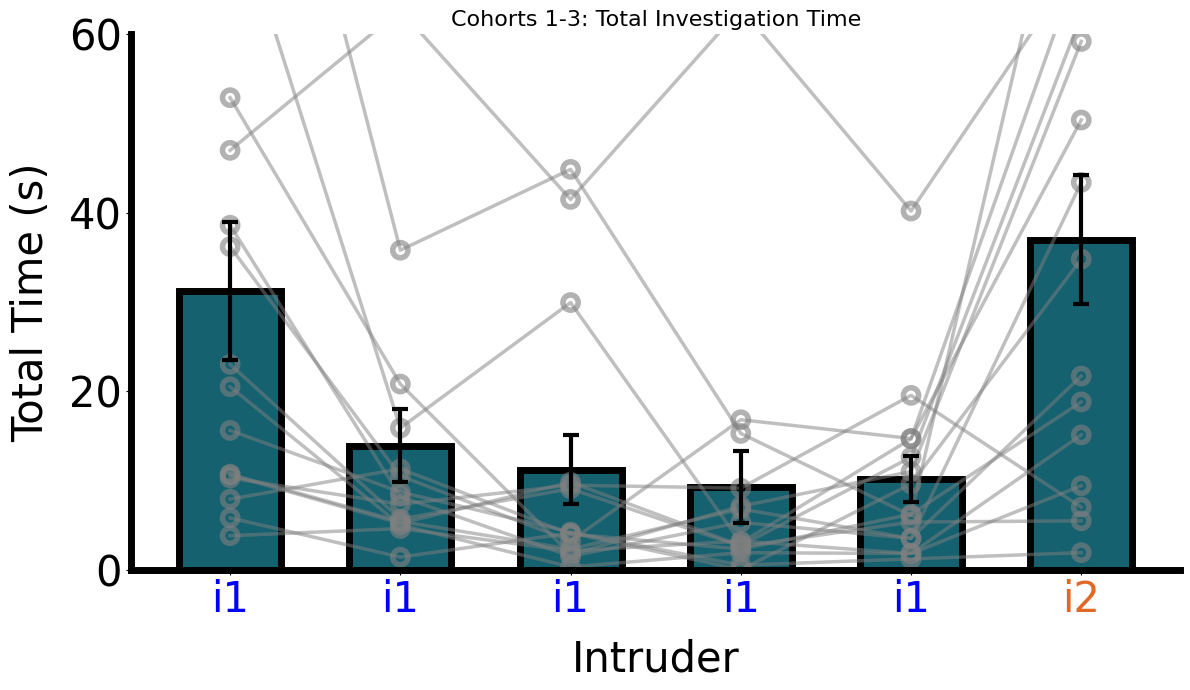

In [25]:
plot_y_across_bouts_gray(
    df=pivot,
    title="Cohorts 1-3: Total Investigation Time",
    ylabel="Total Time (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 60),
    bar_color=brain_region,
    yticks_increment=20,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

# Dopamine Analysis

### Global

In [26]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first = True)

# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(
    use_fractional=True,       # Enable fractional analysis (limits window to max_bout_duration)
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    peak_fall_fraction=0.6,    # Set the fall threshold to 60% of the peak
    allow_bout_extension=True, # Allow extending the bout window if needed
    first=True                 # Consider only the first investigation event per bout
)

Processing behaviors for n7-240821-114717...
Processing behaviors for n2-240507-093913...
Processing behaviors for nn7-250114-100133...
Processing behaviors for nn3-250115-064154...
Processing behaviors for n6-240821-100116...
Processing behaviors for nn1-250115-052028...
Processing behaviors for n1-240507-080133...
Processing behaviors for nn4-250115-072812...
Processing behaviors for n3-240507-115440...
Processing behaviors for nn2-250115-054951...
Processing behaviors for nn5-250114-083827...
Processing behaviors for n5-240821-085040...
Processing behaviors for nn6-250114-093117...
Processing behaviors for n4-240507-140651...
Processing behaviors for nn8-250114-103839...
Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for n2-240507-093913 ...
Computing DA metrics for nn7-250114-100133 ...
Computing DA metrics for nn3-250115-064154 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for nn1-250115-052028 ...
Computing DA metrics for n1-240507-080

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

plot_da_metrics_combined_oneplot_integrated(experiment,  # Use the subset
                                            metric_name="AUC", 
                                            title="Cohorts 1-3: Global DA (Peak)", 
                                            ylabel="AUC", 
                                            xlabel="Bout", 
                                            custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
                                            custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"], 
                                            ylim=(-2, 18), 
                                            bar_color=brain_region, 
                                            yticks_increment=4,
                                            figsize=(14,8), 
                                            pad_inches=0.1)


#plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)

No data available to plot.


In [28]:
# double checking the p-values
from scipy.stats import ttest_rel
import pandas as pd

t_test_results = perform_t_tests_on_bouts(experiment, metric_name="AUC")

T-test between bout 1 and bout 2: t-statistic = 3.1580, p-value = 0.0070
T-test between bout 5 and bout 6: t-statistic = -5.6647, p-value = 0.0001


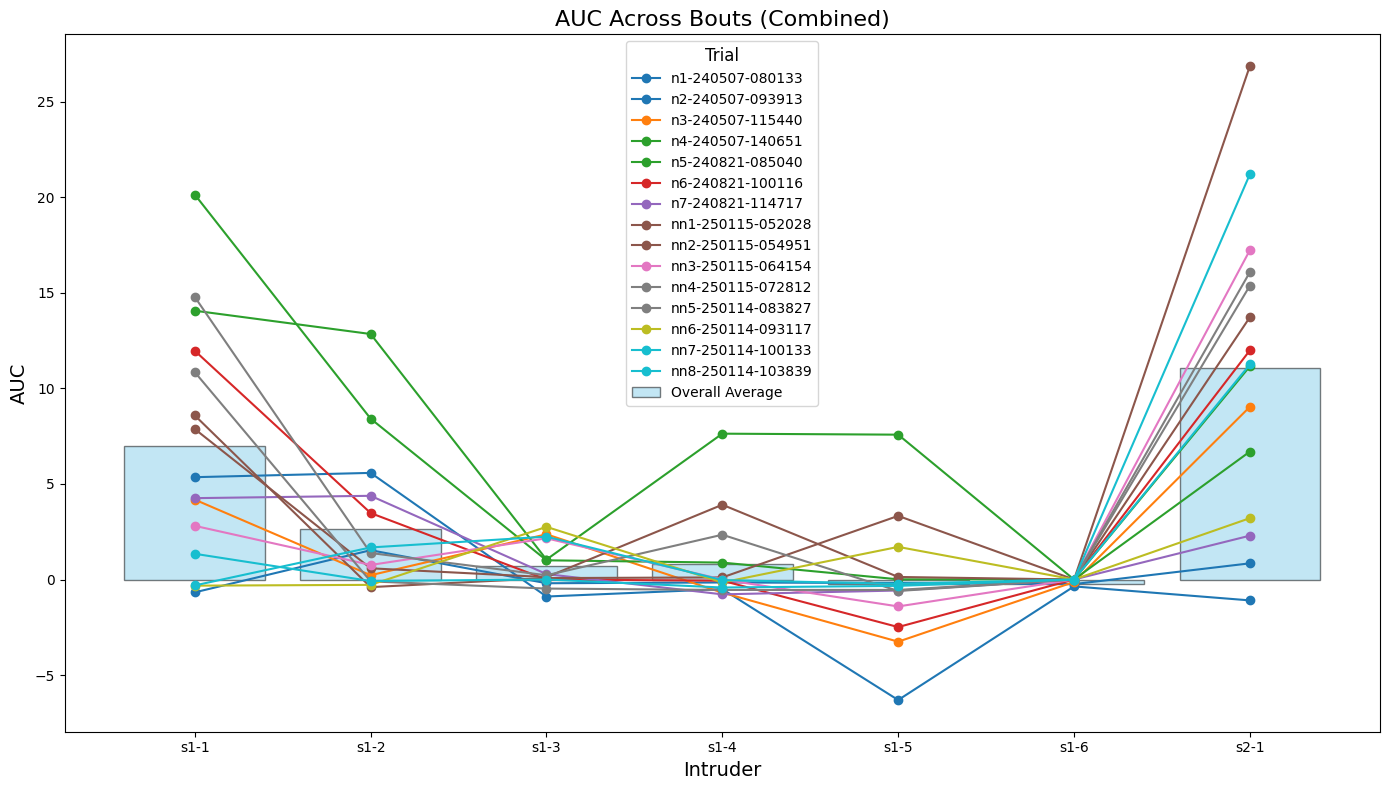

In [29]:
# CHANGE THESE PARAMETERS
# plotting colors for a plot
plot_da_metrics_color_oneplot(experiment, 
                                 metric_name="AUC", 
                                 title="AUC Across Bouts (Combined)",
                                 ylabel="AUC",
                                 xlabel="Intruder",
                                 figsize=(14,8))

## Event-Induced

In [30]:
def extract_bouts_and_behaviors_from_dir(directory_path, bout_definitions):
    """
    Reads all behavior CSV files from a directory, extracts behavior events within bouts,
    and compiles a DataFrame containing labeled subjects and rounds.

    Parameters:
    - directory_path (str): Path to the folder containing behavior CSVs.
    - bout_definitions (list of dict): List defining bout structures with keys:
        - 'prefix': Label for the bout (e.g., "s1", "s2").
        - 'introduced': Event marking the start of the bout.
        - 'removed': Event marking the end of the bout.

    Returns:
    - pd.DataFrame: A DataFrame containing behaviors for all subjects, labeled by subject and round.
    """

    all_data = []  # List to store extracted data from each file

    # Loop through all CSV files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            csv_path = os.path.join(directory_path, filename)
            
            # Extract subject name from filename (assuming format "subjectID_someinfo.csv")
            subject_name = filename.split('_')[0]  

            # Read the CSV
            data = pd.read_csv(csv_path)

            # Ensure 'Start (s)' and 'Stop (s)' are numeric
            data['Start (s)'] = pd.to_numeric(data['Start (s)'], errors='coerce')
            data['Stop (s)'] = pd.to_numeric(data['Stop (s)'], errors='coerce')

            # Create boundary behavior set
            boundary_behaviors = {bd['introduced'] for bd in bout_definitions} | {bd['removed'] for bd in bout_definitions}

            # Function to extract events within bouts
            def extract_bout_events(df, introduced_behavior, removed_behavior, bout_prefix):
                introduced_df = df[df['Behavior'] == introduced_behavior].sort_values('Start (s)').reset_index(drop=True)
                removed_df = df[df['Behavior'] == removed_behavior].sort_values('Start (s)').reset_index(drop=True)
                num_bouts = min(len(introduced_df), len(removed_df))

                rows = []
                for i in range(num_bouts):
                    bout_label = f"{bout_prefix}-{i+1}"
                    bout_start = introduced_df.loc[i, 'Start (s)']
                    bout_end = removed_df.loc[i, 'Start (s)']

                    # Select only behaviors within this bout, excluding boundary behaviors
                    subset = df[
                        (~df['Behavior'].isin(boundary_behaviors)) &
                        (df['Start (s)'] >= bout_start) & 
                        (df['Stop (s)'] <= bout_end)
                    ]

                    # Identify first investigation event per bout
                    first_investigation = (
                        subset[subset['Behavior'] == 'Investigation']
                        .sort_values('Start (s)')
                        .head(1)
                    )

                    for _, row in subset.iterrows():
                        rows.append({
                            'Subject': subject_name,  # Label each row with the subject ID
                            'Bout': bout_label,
                            'Behavior': row['Behavior'],
                            'Event_Start': row['Start (s)'],
                            'Event_End': row['Stop (s)'],
                            'Duration (s)': row['Stop (s)'] - row['Start (s)'],
                            'First Investigation': int(row['Behavior'] == 'Investigation' and not first_investigation.empty and row['Start (s)'] == first_investigation['Start (s)'].values[0])
                        })

                return rows

            # Extract behavior events for all bout definitions
            bout_rows = []
            for bout_def in bout_definitions:
                prefix = bout_def['prefix']
                introduced_behavior = bout_def['introduced']
                removed_behavior = bout_def['removed']
                bout_rows.extend(extract_bout_events(data, introduced_behavior, removed_behavior, prefix))

            all_data.extend(bout_rows)  # Append to the main list

    # Convert to DataFrame
    behaviors_df = pd.DataFrame(all_data)

    return behaviors_df




In [31]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first = True)
new_df = extract_bouts_and_behaviors_from_dir(csv_base_path, bout_definitions)

Processing behaviors for n7-240821-114717...
Processing behaviors for n2-240507-093913...
Processing behaviors for nn7-250114-100133...
Processing behaviors for nn3-250115-064154...
Processing behaviors for n6-240821-100116...
Processing behaviors for nn1-250115-052028...
Processing behaviors for n1-240507-080133...
Processing behaviors for nn4-250115-072812...
Processing behaviors for n3-240507-115440...
Processing behaviors for nn2-250115-054951...
Processing behaviors for nn5-250114-083827...
Processing behaviors for n5-240821-085040...
Processing behaviors for nn6-250114-093117...
Processing behaviors for n4-240507-140651...
Processing behaviors for nn8-250114-103839...


In [32]:
new_df

,Subject,Bout,Behavior,Event_Start,Event_End,Duration (s),First Investigation
0,nn4-250115-072812.csv,s1-1,Investigation,187.8,192.000,4.200,1
1,nn4-250115-072812.csv,s1-1,Approach,204.9,205.999,1.099,0
2,nn4-250115-072812.csv,s1-1,Investigation,206.0,210.800,4.800,0
3,nn4-250115-072812.csv,s1-1,Investigation,215.0,223.700,8.700,0
4,nn4-250115-072812.csv,s1-1,Investigation,215.1,216.700,1.600,0
...,...,...,...,...,...,...,...
701,n7-240821-114717.csv,s1-5,Investigation,945.6,949.100,3.500,1
702,n7-240821-114717.csv,s1-5,Investigation,946.5,947.400,0.900,0
703,n7-240821-114717.csv,s1-5,Investigation,1029.9,1030.200,0.300,0
704,n7-240821-114717.csv,s2-1,Investigation,1124.9,1128.800,3.900,1


In [33]:
def calculate_event_induced_dopamine(df, experiment, pre_time=None, post_time=None, first=True):
    """
    Computes event-induced dopamine metrics and appends them to the dataframe.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing behavior events.
    - experiment: An object that provides access to behavior and dopamine data.
    - pre_time (float): Time (in seconds) before the event start to include.
    - post_time (float): Time (in seconds) after the event start to include.
    - first (bool): If True, compute event-induced dopamine only for the first investigation.
    
    Returns:
    - pd.DataFrame: The input dataframe with additional columns for dopamine metrics.
    """
    
    results = []
    
    # Strip .csv if present in 'Subject' column
    df['Subject'] = df['Subject'].str.replace('.csv', '', regex=False)
    
    for _, row in df.iterrows():
        subject = row['Subject']
        event_start = row['Event_Start']
        
        # If first=True, only process first investigations
        if first and row['First Investigation'] != 1:
            continue
        
        # Retrieve the correct dopamine data for the subject
        trial = experiment.trials.get(subject)
        
        if trial is None or trial.zscore is None:
            print(f"Warning: No signal data found for {subject}, skipping.")
            continue
        
        # Ensure required attributes exist in the trial object
        if trial.timestamps is None or len(trial.timestamps) == 0:
            print(f"Warning: Missing required timestamps in signal data for {subject}, skipping.")
            continue
        
        # Convert timestamps and zscore into a DataFrame
        time_series = pd.DataFrame({
            'Time': trial.timestamps,
            'Z-score': trial.zscore
        })
        
        # Extract relevant time window
        time_window = (time_series['Time'] >= event_start - pre_time) & (time_series['Time'] <= event_start + post_time)
        relevant_data = time_series[time_window]
        
        if relevant_data.empty:
            continue  # Skip if no data in window
        
        z_scores = relevant_data['Z-score'].values
        times = relevant_data['Time'].values
        
        # Compute metrics without using simps
        auc = np.trapezoid(z_scores, times)  # Using numpy's trapezoidal integration
        max_peak = np.max(z_scores)
        time_of_max_peak = times[np.argmax(z_scores)]
        mean_z_score = np.mean(z_scores)
        
        # Append results
        results.append({
            'Subject': subject,
            'Bout': row['Bout'],
            'Behavior': row['Behavior'],
            'Event_Start': event_start,
            'AUC': auc,
            'Max_Peak': max_peak,
            'Time_of_Max_Peak': time_of_max_peak,
            'Mean_Z_Score': mean_z_score,
        })
    
    # Convert results to DataFrame and merge with original
    if results:
        results_df = pd.DataFrame(results)
        df = df.merge(results_df, on=['Subject', 'Bout', 'Behavior', 'Event_Start'], how='left')
    else:
        print("No event-induced dopamine metrics were computed.")
    
    return df


In [34]:
# Call the function
event_induced_df = calculate_event_induced_dopamine(
    df=new_df, experiment=experiment,
    pre_time=4,  # Time before event to analyze
    post_time=9,  # Time after event to analyze
    first=True  # Consider only first investigation
)

from scipy.stats import ttest_rel
'''
def plot_da_metrics_combined_oneplot_integrated(event_induced_df, 
                                                metric_name="Mean_Z_Score", 
                                                title="Combined DA Metrics", 
                                                ylabel="DA Metric", 
                                                xlabel="Bout", 
                                                custom_xtick_labels=None, 
                                                custom_xtick_colors=None, 
                                                ylim=None, 
                                                bar_color="#00B7D7", 
                                                yticks_increment=None, 
                                                figsize=(14,8), 
                                                pad_inches=0.1):
    """
    Plots the computed DA metrics across 6 specific bouts for all subjects in event_induced_df.
    """
    
    if metric_name not in event_induced_df.columns:
        print(f"Error: Metric '{metric_name}' not found in event_induced_df.")
        return
    
    # Group by Bout and compute means per subject
    grouped_df = event_induced_df.groupby(["Subject", "Bout"])[metric_name].mean().reset_index()
    
    # Select only 6 bouts: first 5 as "i1", last one as "i2"
    selected_bouts = grouped_df["Bout"].unique()[:6]
    grouped_df = grouped_df[grouped_df["Bout"].isin(selected_bouts)]
    
    # Pivot data for line plots: rows=Subject, columns=Bout, values=metric_name.
    try:
        pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values=metric_name)
    except Exception as e:
        print("Error pivoting data for line plots:", e)
        return
    pivot_df = pivot_df.fillna(0)
    
    # Compute overall mean and SEM for each Bout across all subjects.
    overall_stats = grouped_df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, facecolor="none")
    
    # Bar chart with error bars
    ax.bar(overall_stats["Bout"], overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))
    
    # Overlay individual subject lines
    for subject in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[subject], linestyle='-', color='gray', 
                alpha=0.5, linewidth=3, marker='o', markerfacecolor='none', markeredgecolor='gray', markeredgewidth=2, markersize=10)
    
    # Set labels and title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    if title is not None:
        ax.set_title(title, fontsize=28)
    
    # Set x-tick labels and colors
    xtick_labels = ["i1"]*5 + ["i2"]
    xtick_colors = ["blue"]*5 + ["#E06928"]
    
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(xtick_labels, fontsize=28)
    
    for tick, color in zip(ax.get_xticklabels(), xtick_colors):
        tick.set_color(color)
    
    # Adjust y-limits
    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    
    # Set y-ticks based on yticks_increment
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)
        ax.tick_params(axis='y', labelsize=28)  # Adjust y-tick font size to match x-tick labels
    
    # Remove right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    
    # Perform paired t-tests on selected bouts
    def perform_t_tests(df, metric_name):
        if len(selected_bouts) < 6:
            return None
        
        bout_1 = df[df["Bout"] == selected_bouts[0]][metric_name].values
        bout_2 = df[df["Bout"] == selected_bouts[1]][metric_name].values
        bout_5 = df[df["Bout"] == selected_bouts[4]][metric_name].values
        bout_6 = df[df["Bout"] == selected_bouts[5]][metric_name].values
        
        min_length_1 = min(len(bout_1), len(bout_2))
        min_length_2 = min(len(bout_5), len(bout_6))
        
        bout_1, bout_2 = bout_1[:min_length_1], bout_2[:min_length_1]
        bout_5, bout_6 = bout_5[:min_length_2], bout_6[:min_length_2]
        
        t_stat_1, p_value_1 = ttest_rel(bout_1, bout_2)
        t_stat_2, p_value_2 = ttest_rel(bout_5, bout_6)
        
        return {"p_value_1": p_value_1, "p_value_2": p_value_2}
    
    t_test_results = perform_t_tests(event_induced_df, metric_name)
    
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        
        if t_test_results["p_value_1"] < 0.05:
            ax.plot([0, 1], [max_y, max_y], color='black', linewidth=5)
            ax.text(0.5, max_y + sig_y_offset / 2, "*", fontsize=40, ha='center', color='black')
        
        if t_test_results["p_value_2"] < 0.05:
            ax.plot([4, 5], [max_y, max_y], color='black', linewidth=5)
            ax.text(4.5, max_y + sig_y_offset / 2, "*", fontsize=40, ha='center', color='black')
    
    plt.tight_layout(pad=pad_inches)
    plt.show()

plot_da_metrics_combined_oneplot_integrated(
    event_induced_df=event_induced_df,  # The processed dataframe with dopamine metrics
    metric_name="Mean_Z_Score",  # The DA metric to plot
    title="Event-Induced DA Response Across Bouts",
    ylabel="Baseline Z-Scored ΔF/F",
    xlabel="Intruder",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(-5,5),  # Auto-adjust y-axis limits
    bar_color=brain_region,  # Bar color
    yticks_increment=5,  # Y-axis tick increment
    figsize=(14, 8),
    pad_inches=0.1
)
'''


'\ndef plot_da_metrics_combined_oneplot_integrated(event_induced_df, \n                                                metric_name="Mean_Z_Score", \n                                                title="Combined DA Metrics", \n                                                ylabel="DA Metric", \n                                                xlabel="Bout", \n                                                custom_xtick_labels=None, \n                                                custom_xtick_colors=None, \n                                                ylim=None, \n                                                bar_color="#00B7D7", \n                                                yticks_increment=None, \n                                                figsize=(14,8), \n                                                pad_inches=0.1):\n    """\n    Plots the computed DA metrics across 6 specific bouts for all subjects in event_induced_df.\n    """\n    \n    if metric_name not in e

## Baseline

# messin around

In [35]:
def hab_dishab_plot_y_across_bouts_colored(
    df, 
    title='Mean Across Bouts', 
    ylabel='Mean Value', 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=None, 
    bar_color='#00B7D7',
    yticks_increment=None, 
    xlabel='Intruder',
    figsize=(12,7), 
    pad_inches=1,
    cmap_name='tab10'
):
    """
    Plots the mean values (with SEM error bars) for each bout, plus each subject's data 
    in a unique color. The color map can be customized via `cmap_name` (e.g. 'tab10', 'tab20').
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate means and SEM across subjects
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))

    # Create a color map to get a unique color for each subject
    cmap = plt.cm.get_cmap(cmap_name, len(df.index))

    # -------------------------------------------------------
    # Plot each subject's data in a unique color + label
    # -------------------------------------------------------
    for i, idx in enumerate(df.index):
        subject_color = cmap(i)
        label = f"Subject {idx}"  # <--- ADDED: a label for the legend
        ax.plot(
            x, 
            df.loc[idx, :], 
            color=subject_color, 
            alpha=0.7, 
            marker='o', 
            linewidth=1,
            label=label             # <--- ADDED: pass the label here
        )

    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)

    # Set x-axis ticks/labels
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)

    # Labels and title
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Y-axis limit
    if ylim is not None:
        ax.set_ylim(ylim)

    # Custom y-ticks increment
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))

    # -------------------------------------------------------
    # ADDED LEGEND: show the subject labels
    # -------------------------------------------------------
    # You can place the legend in many ways. For example, to the right:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # or simply:
    # ax.legend(loc='best')

    plt.tight_layout(pad=pad_inches)
    plt.show()


# Suppose pivot_df is the DataFrame used in your plot function.
# Fill NaN with 0 for all subjects/bouts.
    pivot_df = pivot_df.fillna(0)

# Now re-plot
hab_dishab_plot_y_across_bouts_colored(
    df=pivot_df,
    title="Mean Investigation Time Across Bouts (Colored by Subject)",
    ylabel="Investigation Time (s)",
    ylim=(0, 5),
    cmap_name='tab20'
)

NameError: name 'pivot_df' is not defined

Bout      s1-1     s1-2    s1-3      s1-4   s1-5   s2-1
Subject                                                
1        1.399  1.96600  0.0000  0.000000  0.932  0.000
2        1.177  1.91000  0.9990  1.032500  1.399  0.000
3        1.166  0.74925  0.9655  1.487667  1.999  0.000
4        0.000  1.19900  1.7655  0.999333  0.999  1.733
6        1.599  2.49900  0.0000  2.799000  0.000  2.349


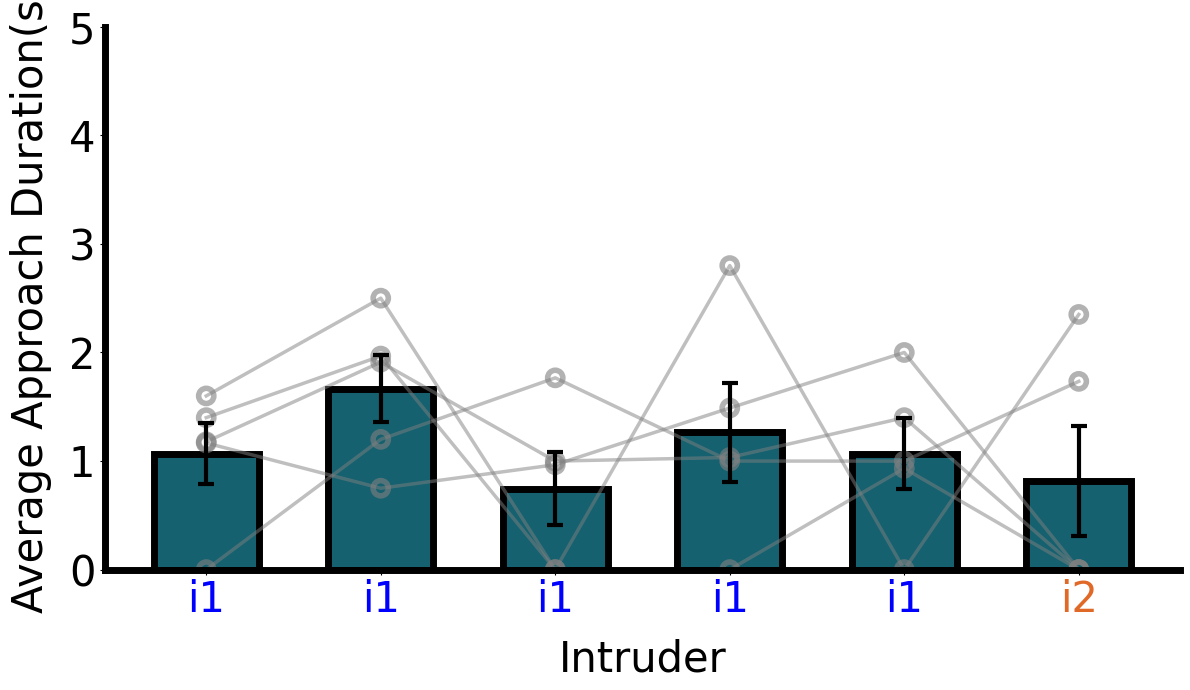

In [ ]:
# Define the desired behavior to include in the analysis
desired_behavior = "Approach"  # Change to "Investigation" if needed

# --- Create combined summary DataFrame (from your trials) ---
summary_df = create_subject_summary_df(trials)

# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Approach events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Approach', bout_time_threshold=1)
    # Remove Approach events shorter than 0.5 seconds.
    nn.remove_short_behaviors(behavior_name='Approach', min_duration=0.5)
    
# --- Filter Summary DataFrame by Specific Bouts ---
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# --- Filter to include only the desired behavior (e.g., Approach) ---
filtered_summary_df = filtered_summary_df[filtered_summary_df["Behavior"] == desired_behavior]

# (Optional) If you want to exclude a particular subject, e.g., Subject 5:
filtered_summary_df = filtered_summary_df[filtered_summary_df["Subject"] != 5]

# --- Group by Subject and Bout and sum Duration (s) to ensure unique pairs ---
grouped_df = filtered_summary_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()

# --- Pivot the grouped DataFrame so that rows are subjects and columns are bouts ---
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # Fill missing values with 0

# Now, pivot_df is ready to be passed to your plotting function.
print(pivot_df.head())

# Then call your plotting function
plot_y_across_bouts_gray(
    df=pivot_df,
    title=None,
    ylabel="Average Approach Duration(s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 5),
    bar_color=brain_region,
    yticks_increment=1,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)


/var/folders/tj/nfn3dynx2n19r7566d88xmsc0000gn/T/ipykernel_21186/1917977511.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(df.index))


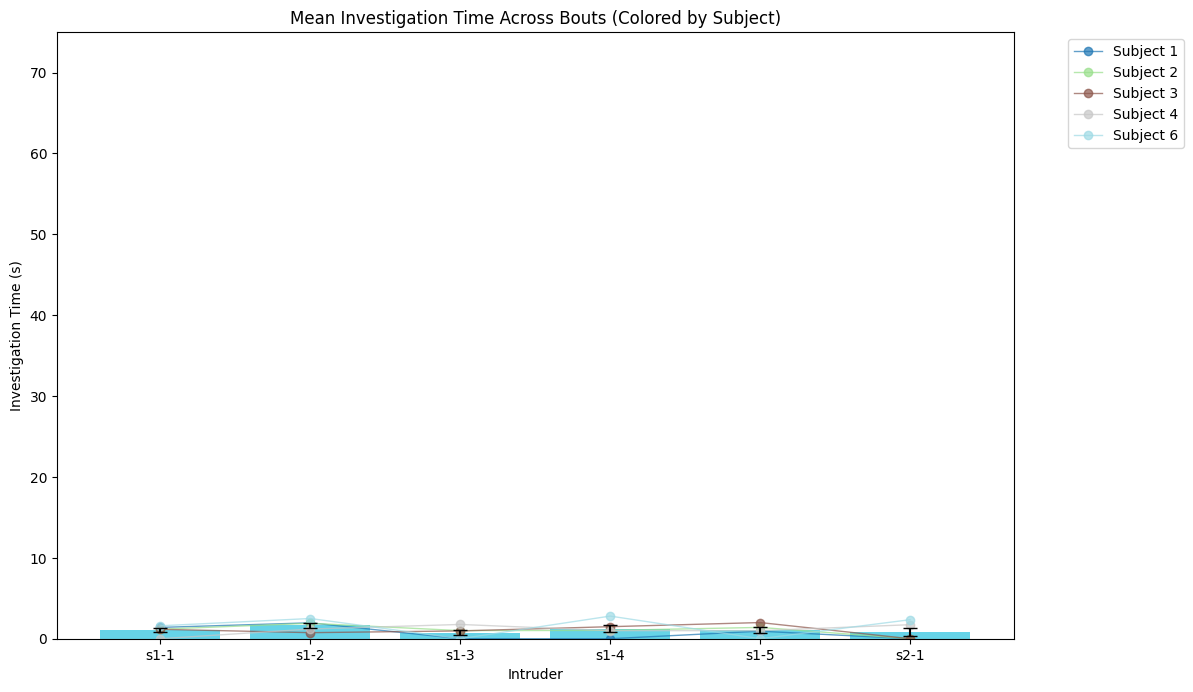

UnboundLocalError: cannot access local variable 'pivot_df' where it is not associated with a value

In [ ]:
# Suppose pivot_df is the DataFrame used in your plot function.
# Fill NaN with 0 for all subjects/bouts.
pivot_df = pivot_df.fillna(0)

# Now re-plot
hab_dishab_plot_y_across_bouts_colored(
    df=pivot_df,
    title="Mean Investigation Time Across Bouts (Colored by Subject)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)

In [ ]:
# new code i'm trying
filtered_summary_df = automate_investigation_workflow(
    experiment=experiment,
    trial_keys=["n1-240507-080133", "n2-240507-093913", "n3-240507-115440", 
                "n4-240507-140651", "n5-240821-085040", "n6-240821-100116", "n7-240821-114717"],
    combine_threshold=1,
    min_duration=0.5,
    desired_bouts=["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"],
    calc_method="average"
)
# if you want to omit a subject
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]


grouped_df = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # Ensure no missing numeric values

plot_y_across_bouts_gray(
    df=pivot_df,
    title="Average Bout Duration",
    ylabel="Avg Bout Duration (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 80),
    bar_color=brain_region,  # make sure brain_region is defined, e.g., brain_region = "#00B7D7"
    yticks_increment=20,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

KeyError: 'Duration (s)'

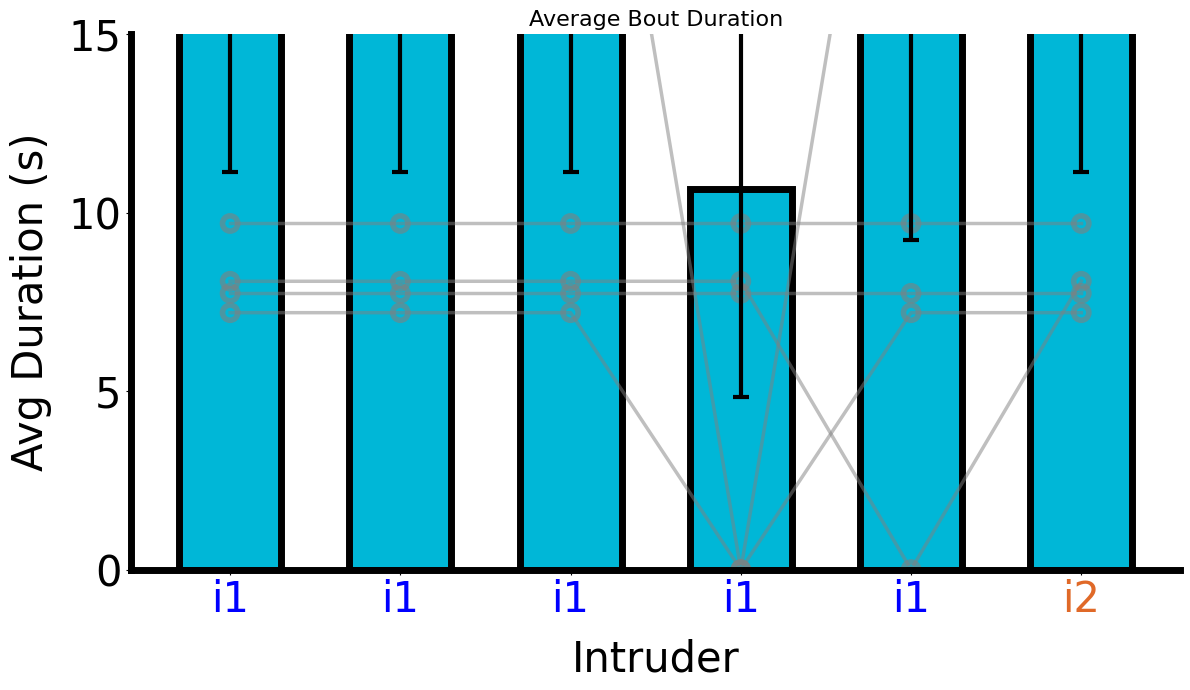

In [ ]:
# 2) Group by (Subject, Bout) and compute the MEAN
grouped_df = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()

# 3) Pivot the grouped DataFrame (rows=subjects, cols=bouts, values=mean duration)
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # fill missing with 0 if needed

# 4) Plot using the "Average Bout Duration" label
plot_y_across_bouts_gray(
    df=pivot_df,
    title="Average Bout Duration",
    ylabel="Avg Duration (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 15),    # set an appropriate y-limit if you expect smaller values
    bar_color="#00B7D7",
    yticks_increment=5,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

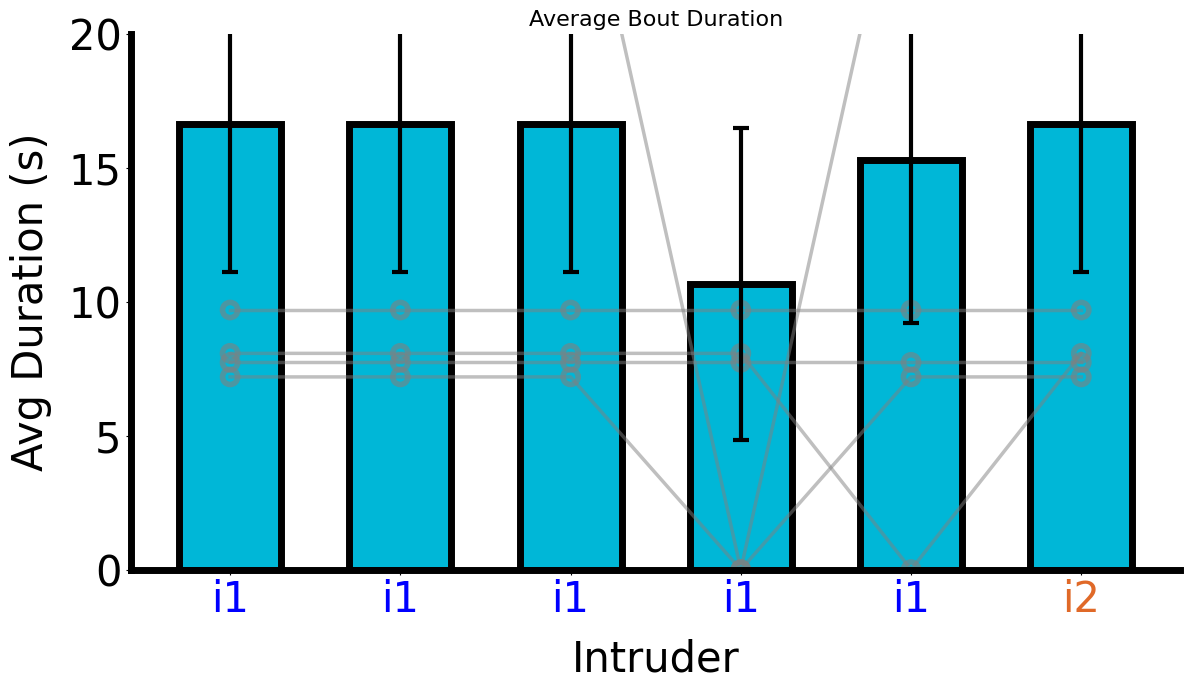

In [ ]:
# 2) Group by (Subject, Bout) and compute the MEAN
grouped_df = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()

# 3) Pivot the grouped DataFrame (rows=subjects, cols=bouts, values=mean duration)
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # fill missing with 0 if needed

# --- Plot the Total Investigation Time Across Bouts for the Filtered Bouts ---
plot_y_across_bouts_gray(
    df=pivot_df,
    title="Average Bout Duration",
    ylabel="Avg Duration (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 20),    # set an appropriate y-limit if you expect smaller values
    bar_color="#00B7D7",
    yticks_increment=5,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

In [ ]:
nn1 = experiment.trials['n1-240507-080133']
nn2 = experiment.trials['n2-240507-093913']
nn3 = experiment.trials['n3-240507-115440']
nn4 = experiment.trials['n4-240507-140651']
nn5 = experiment.trials['n5-240821-085040']
nn6 = experiment.trials['n6-240821-100116']
nn7 = experiment.trials['n7-240821-114717']

for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=2)

# Read each CSV into a DataFrame
df1 = nn1.behaviors
df2 = nn2.behaviors
df3 = nn3.behaviors
df4 = nn4.behaviors
df5 = nn5.behaviors
df6 = nn6.behaviors
df7 = nn7.behaviors

# Create a list of the DataFrames
trials = [df1, df2, df3, df4, df5, df6, df7]

# Create one combined summary DataFrame (7 subjects total)
summary_df = create_subject_summary_df(trials)
# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=0.5)



# --- Combine Processed Behaviors into a Summary DataFrame ---
trials = [
    nn1.behaviors, nn2.behaviors, nn3.behaviors,
    nn4.behaviors, nn5.behaviors, nn6.behaviors, nn7.behaviors
]


summary_df = create_subject_summary_df(trials)

# --- Filter Summary DataFrame by Specific Bouts ---
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# get rid of 5
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]

# 1) Remove Subject 5
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]






In [ ]:
# 1) Process each subject's DataFrame (nn1.behaviors, nn2.behaviors, etc.)
processed_dfs = []
for df in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events within a 5-second threshold
    merged_df = Trial.combine_consecutive_behaviors(
        df, behavior_name='Investigation', bout_time_threshold=5
    )
    # Remove Investigation events shorter than 1 second
    short_removed_df = Trial.remove_short_behaviors(
        merged_df, behavior_name='Investigation', min_duration=1
    )
    processed_dfs.append(short_removed_df)

# 2) Combine the processed DataFrames into a single summary DataFrame
summary_df = create_subject_summary_df(processed_dfs)

# 3) Remove Subject 5 from the summary (i.e., rows where Subject == 5)
summary_df = summary_df[summary_df["Subject"] != 5]

# 4) Filter the summary DataFrame to include only the desired bouts
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# 5) Plot the total Investigation Time across bouts, y-axis from 0 to 75
plot_behavior_metric(
    df=filtered_summary_df,
    behavior="Investigation",
    metric="investigation_time",  # or "average_bout_duration"
    title="Total Investigation Time Across Selected Bouts (All Subjects, No Subject 5)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75)
)

AttributeError: 'NoneType' object has no attribute 'behaviors'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Standalone Functions for Behavior Processing
# --------------------------
def combine_consecutive_behaviors(df, behavior_name='all', bout_time_threshold=1):
    """
    Combines consecutive behavior events if they occur within the specified time threshold.
    
    Parameters:
      df (DataFrame): Input DataFrame with columns ['Bout', 'Behavior', 'Event_Start', 'Event_End', 'Duration (s)'].
      behavior_name (str): If not 'all', only process rows matching this behavior.
      bout_time_threshold (float): Maximum gap (in seconds) allowed between consecutive events to merge them.
      
    Returns:
      DataFrame with merged events.
    """
    if df.empty:
        return df.copy()
    
    # If processing only a specific behavior, work on that subset
    if behavior_name != 'all':
        working_df = df[df['Behavior'] == behavior_name].copy()
    else:
        working_df = df.copy()
    
    # Sort by Bout, Behavior, and Event_Start to ensure proper merging
    working_df = working_df.sort_values(by=['Bout', 'Behavior', 'Event_Start']).reset_index(drop=True)
    
    combined_rows = []
    # Group by Bout and Behavior to merge events in each group
    for (bout, behavior), group in working_df.groupby(['Bout', 'Behavior']):
        group = group.sort_values('Event_Start').reset_index(drop=True)
        current_start = group.loc[0, 'Event_Start']
        current_end = group.loc[0, 'Event_End']
        
        for i in range(1, len(group)):
            next_start = group.loc[i, 'Event_Start']
            next_end = group.loc[i, 'Event_End']
            
            # If the gap between events is within threshold, merge them
            if next_start - current_end <= bout_time_threshold:
                current_end = next_end  # extend the current event
            else:
                combined_rows.append({
                    'Bout': bout,
                    'Behavior': behavior,
                    'Event_Start': current_start,
                    'Event_End': current_end,
                    'Duration (s)': current_end - current_start
                })
                # Reset to the next event
                current_start = next_start
                current_end = next_end
        
        # Append the last merged event in the group
        combined_rows.append({
            'Bout': bout,
            'Behavior': behavior,
            'Event_Start': current_start,
            'Event_End': current_end,
            'Duration (s)': current_end - current_start
        })
    
    return pd.DataFrame(combined_rows)


def remove_short_behaviors(df, behavior_name='all', min_duration=0):
    """
    Removes events with duration less than min_duration.
    
    Parameters:
      df (DataFrame): Input DataFrame with a 'Duration (s)' column.
      behavior_name (str): If not 'all', only process rows matching this behavior.
      min_duration (float): Minimum duration (in seconds) required to keep an event.
      
    Returns:
      Filtered DataFrame.
    """
    if df.empty:
        return df.copy()
    
    if behavior_name != 'all':
        working_df = df[df['Behavior'] == behavior_name].copy()
    else:
        working_df = df.copy()
    
    working_df = working_df[working_df['Duration (s)'] >= min_duration]
    return working_df.reset_index(drop=True)

# --------------------------
# Functions for Creating Summary & Plotting
# --------------------------
def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each representing one subject's processed behaviors),
    assigns a unique Subject ID (1 to N) to each DataFrame, and computes:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        temp_df["Subject"] = subject_id
        
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1
    
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


def hab_dishab_plot_y_across_bouts_gray(df, 
                                        title='Mean Across Bouts', 
                                        ylabel='Mean Value', 
                                        custom_xtick_labels=None, 
                                        custom_xtick_colors=None, 
                                        ylim=None, 
                                        bar_color='#00B7D7',
                                        yticks_increment=None, 
                                        xlabel='Intruder',
                                        figsize=(12,7), 
                                        pad_inches=1):
    """
    Plots the mean values (with SEM error bars) for each bout, and overlays each subject's data in gray.
    
    Parameters:
      df (DataFrame): rows = subjects, columns = bouts, values = metric to plot.
      title, ylabel, etc.: standard plotting options.
    """
    fig, ax = plt.subplots(figsize=figsize)
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))
    
    # Plot each subject's data in gray
    for idx in df.index:
        ax.plot(x, df.loc[idx, :], color='gray', alpha=0.5, marker='o', linewidth=1)
    
    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)
    
    # Configure x-tick labels and colors if provided
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))
    
    plt.tight_layout(pad=pad_inches)
    plt.show()


def plot_behavior_metric(df, 
                         behavior="Investigation", 
                         metric="investigation_time",
                         title='Mean Across Bouts',
                         ylabel='Mean Value',
                         ylim=None):
    """
    Filters the summary DataFrame by a given Behavior, then computes:
      - 'investigation_time': sum of "Duration (s)" per Subject & Bout
      - 'average_bout_duration': mean of "Duration (s)" per Subject & Bout
    Pivots to a subject-by-bout DataFrame and plots with hab_dishab_plot_y_across_bouts_gray.
    """
    filtered_df = df[df["Behavior"] == behavior].copy()
    
    if metric == "investigation_time":
        grouped = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
        plot_label = "Investigation Time (Sum)"
    elif metric == "average_bout_duration":
        grouped = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
        plot_label = "Average Bout Duration (Mean)"
    else:
        raise ValueError("metric must be either 'investigation_time' or 'average_bout_duration'")
    
    pivot_df = grouped.pivot(index="Subject", columns="Bout", values="Duration (s)")
    hab_dishab_plot_y_across_bouts_gray(
        df=pivot_df,
        title=title,
        ylabel=ylabel if ylabel else plot_label,
        ylim=ylim
    )

# --------------------------
# EXAMPLE USAGE
# --------------------------
# Assume you already have DataFrames for each subject's behaviors.
# For example, nn1.behaviors, nn2.behaviors, ... nn7.behaviors have been created elsewhere.
# Each DataFrame should include these columns:
# ['Bout', 'Behavior', 'Event_Start', 'Event_End', 'Duration (s)']

# Process each subject's behaviors (standalone, without classes)
processed_dfs = []
for df in [nn1.behaviors, nn2.behaviors, nn3.behaviors, nn4.behaviors, nn5.behaviors, nn6.behaviors, nn7.behaviors]:
    # Merge consecutive Investigation events within a 1-second threshold.
    merged_df = combine_consecutive_behaviors(df, behavior_name='Investigation', bout_time_threshold=5)
    # Remove Investigation events shorter than 0.5 seconds.
    filtered_df = remove_short_behaviors(merged_df, behavior_name='Investigation', min_duration=1)
    processed_dfs.append(filtered_df)

# Combine the processed DataFrames into a single summary DataFrame.
summary_df = create_subject_summary_df(processed_dfs)

# Filter the summary DataFrame to include only the desired bouts.
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

bouts = ['s1_1', 's1_2', 's1_3', 's1_4', 's1_5','s2_1']
custom_xtick_labels = ['i1', 'i1','i1','i1','i1','i2',]
custom_xtick_colors = ['blue', 'blue', 'blue', 'blue', 'blue', '#E06928']

# Plot the total Investigation Time across bouts with the y-axis set from 0 to 60.
plot_behavior_metric(
    df=filtered_summary_df,
    behavior="Investigation",
    metric="investigation_time",  # Alternatively, use "average_bout_duration"
    title="Total Investigation Time Across Selected Bouts (All Subjects)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75)
)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plot_behavior_metric_colored(
    df=filtered_summary_df,  # The full summary DataFrame
    behavior="Investigation",
    metric="investigation_time",
    title="Mean Investigation Time Across Bouts (Colored by Subject)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)

In [ ]:
def hab_dishab_plot_y_across_bouts_colored(
    df, 
    title='Mean Across Bouts', 
    ylabel='Mean Value', 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=None, 
    bar_color='#00B7D7',
    yticks_increment=None, 
    xlabel='Intruder',
    figsize=(12,7), 
    pad_inches=1,
    cmap_name='tab10'
):
    """
    Plots the mean values (with SEM error bars) for each bout, plus each subject's data 
    in a unique color. The color map can be customized via `cmap_name` (e.g. 'tab10', 'tab20').
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate means and SEM across subjects
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))

    # Create a color map to get a unique color for each subject
    cmap = plt.cm.get_cmap(cmap_name, len(df.index))

    # -------------------------------------------------------
    # Plot each subject's data in a unique color + label
    # -------------------------------------------------------
    for i, idx in enumerate(df.index):
        subject_color = cmap(i)
        label = f"Subject {idx}"  # <--- ADDED: a label for the legend
        ax.plot(
            x, 
            df.loc[idx, :], 
            color=subject_color, 
            alpha=0.7, 
            marker='o', 
            linewidth=1,
            label=label             # <--- ADDED: pass the label here
        )

    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)

    # Set x-axis ticks/labels
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)

    # Labels and title
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Y-axis limit
    if ylim is not None:
        ax.set_ylim(ylim)

    # Custom y-ticks increment
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))

    # -------------------------------------------------------
    # ADDED LEGEND: show the subject labels
    # -------------------------------------------------------
    # You can place the legend in many ways. For example, to the right:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # or simply:
    # ax.legend(loc='best')

    plt.tight_layout(pad=pad_inches)
    plt.show()

# Filter out Subject 5 from the summary DataFrame before pivoting
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]

# Re-run the analysis and plotting with the filtered data
plot_behavior_metric_colored(
    df=filtered_df,  # Now without Subject 5
    behavior="Investigation",
    metric="investigation_time",
    title="Mean Investigation Time Across Bouts (Colored by Subject, Without Subject 5)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)

/var/folders/tj/nfn3dynx2n19r7566d88xmsc0000gn/T/ipykernel_31048/631157042.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(df.index))


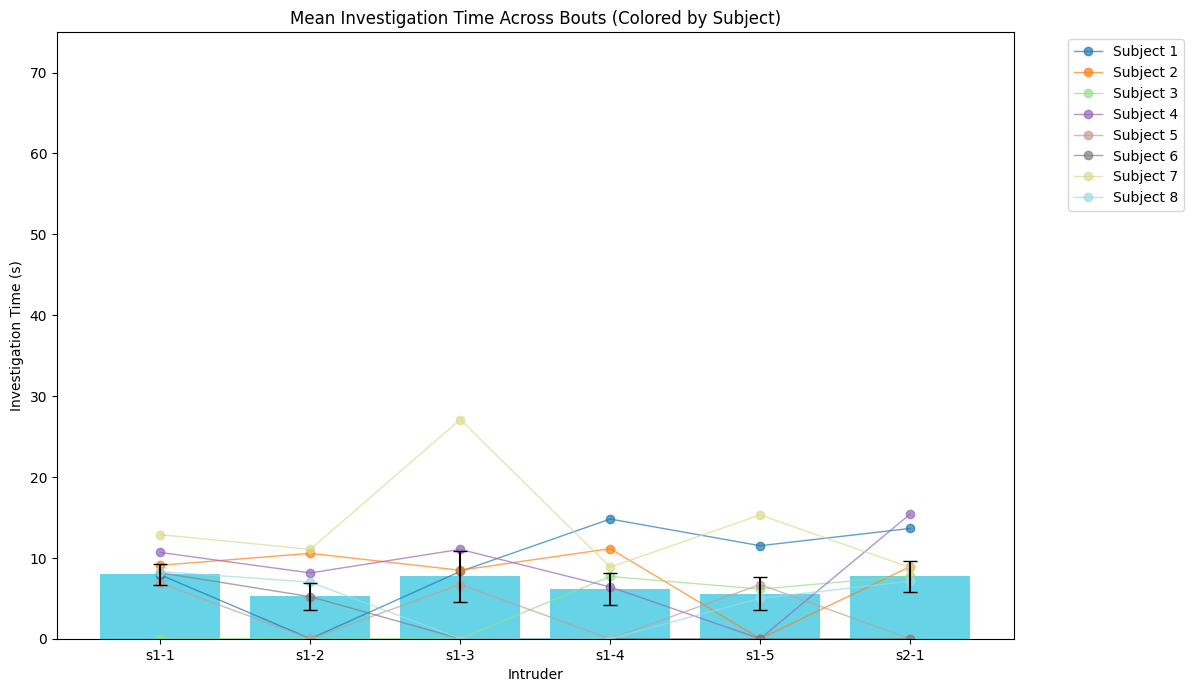

UnboundLocalError: cannot access local variable 'pivot_df' where it is not associated with a value

In [ ]:
def hab_dishab_plot_y_across_bouts_colored(
    df, 
    title='Mean Across Bouts', 
    ylabel='Mean Value', 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=None, 
    bar_color='#00B7D7',
    yticks_increment=None, 
    xlabel='Intruder',
    figsize=(12,7), 
    pad_inches=1,
    cmap_name='tab10'
):
    """
    Plots the mean values (with SEM error bars) for each bout, plus each subject's data 
    in a unique color. The color map can be customized via `cmap_name` (e.g. 'tab10', 'tab20').
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate means and SEM across subjects
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))

    # Create a color map to get a unique color for each subject
    cmap = plt.cm.get_cmap(cmap_name, len(df.index))

    # -------------------------------------------------------
    # Plot each subject's data in a unique color + label
    # -------------------------------------------------------
    for i, idx in enumerate(df.index):
        subject_color = cmap(i)
        label = f"Subject {idx}"  # <--- ADDED: a label for the legend
        ax.plot(
            x, 
            df.loc[idx, :], 
            color=subject_color, 
            alpha=0.7, 
            marker='o', 
            linewidth=1,
            label=label             # <--- ADDED: pass the label here
        )

    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)

    # Set x-axis ticks/labels
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)

    # Labels and title
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Y-axis limit
    if ylim is not None:
        ax.set_ylim(ylim)

    # Custom y-ticks increment
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))

    # -------------------------------------------------------
    # ADDED LEGEND: show the subject labels
    # -------------------------------------------------------
    # You can place the legend in many ways. For example, to the right:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # or simply:
    # ax.legend(loc='best')

    plt.tight_layout(pad=pad_inches)
    plt.show()


# Suppose pivot_df is the DataFrame used in your plot function.
# Fill NaN with 0 for all subjects/bouts.
    pivot_df = pivot_df.fillna(0)

# Now re-plot
hab_dishab_plot_y_across_bouts_colored(
    df=pivot_df,
    title="Mean Investigation Time Across Bouts (Colored by Subject)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)
